In [1]:
from MelodyLSTMEmbV2 import MelodyLSTMEmb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import pretty_midi

In [2]:
num_epochs = 100
learning_rate = 1e-6

input_size = 56 #number of features
hidden_size = 512 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 36 #number of output classes 

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
mlstm = MelodyLSTMEmb(input_size, hidden_size, output_size, num_layers, device)
mlstm.load_state_dict(torch.load('../models/muse2_t10000_bce_w32/checkpoint-10.pth')) 
mlstm.eval()
mlstm.to(device)

Device cuda


MelodyLSTMEmb(
  (embedding): Embedding(51, 10)
  (lstm): LSTM(56, 512, batch_first=True)
  (fc_1): Linear(in_features=512, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=36, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [4]:
embeddings = mlstm.embedding.weight.data.cpu().numpy()

In [5]:
with open('../data/chords/CHORD_DICT.pickle', 'rb') as f: 
    CHORD_DICT = pickle.load(f)

In [6]:
with open('../data/chords_reduced/CHORD_TO_EMB.pickle', 'rb') as f:
    CHORD_TO_EMB = pickle.load(f)

In [7]:
pca = PCA(n_components=2)

In [8]:
reduced = pca.fit_transform(embeddings)

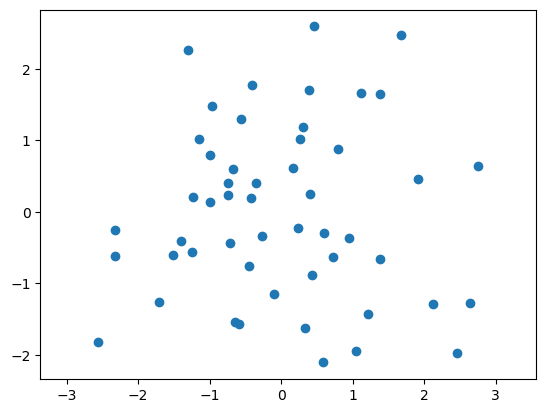

In [9]:
plt.figure()
plt.scatter(x=reduced[:,0], y=reduced[:,1])
plt.axis('equal')
plt.show()

In [10]:
triad_dict = {
    'C': (0, 4, 7),
    'C#': (1, 5, 8),
    'D': (2, 6, 9),
    'D#': (3, 7, 10), 
    'E': (4, 8, 11),
    'F': (0, 5, 9),
    'F#': (1, 6, 10),
    'G': (2, 7, 11),
    'G#': (0, 3, 8),
    'A': (1, 4, 9),
    'A#': (2, 5, 10),
    'B': (3, 6, 11), 
    'Cm': (0, 3, 7),
    'C#m': (1, 4, 8),
    'Dm': (2, 5, 9),
    'D#m': (3, 6, 10),
    'Em': (4, 7, 11),
    'Fm': (0, 5, 8),
    'F#m': (1, 6, 9),
    'Gm': (2, 7, 10),
    'G#m': (3, 8, 11),
    'Am': (0, 4, 9),
    'A#m': (1, 5, 10),
    'Bm': (2, 6, 11)
}

In [11]:
EMB_TO_CHORD = {v: k for k, v in CHORD_TO_EMB.items()}

In [12]:
def get_embedding_chord(chord):
    triad = triad_dict[chord]
    triad = triad[0] * 10000 + triad[1] * 100 + triad[2]
    idx = CHORD_DICT.index(triad)
    emb = CHORD_TO_EMB[idx]
    return emb

In [13]:
cof_emb = np.zeros((24, 10))
for i, chord in enumerate(triad_dict.keys()):
    try:
        eid = get_embedding_chord(chord)
    except:
        eid = 50
    cof_emb[i, :] = embeddings[eid]

In [14]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(cof_emb)

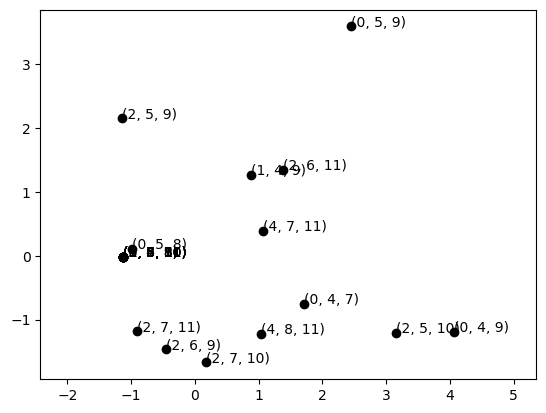

In [15]:
plt.figure()
plt.scatter(x=reduced[:,0], y=reduced[:,1], c='black')

for i, chord in enumerate(triad_dict.values()):
    plt.text(reduced[i, 0], reduced[i, 1], f'{chord}')

plt.axis('equal')
plt.show()

In [16]:
def select_note(p):
    possible = p.detach().cpu().numpy().reshape(-1)
    possible = np.asarray(possible > 0.2).nonzero()[0]
    # print(possible)
    return possible[np.random.choice(possible.shape[0])]

In [17]:
def generate_melody_compass(chord, chord_next, prev=None, ts=8):
    notes = []
    if prev == None:
        prev = torch.zeros(38)
        prev[-1] = chord_next
        prev[-2] = chord
        prev = torch.reshape(prev, (1, 1, -1))
    
    for _ in range(ts):
        prev = prev.to(device)
        p = mlstm(prev)
        notes.append(select_note(p))
        
        last = torch.zeros_like(prev[:,-1,:])
        last = torch.reshape(last, (1, 1, -1))
        last[:,:,notes[-1]] = 1
        last[:, :, -2] = chord
        last[:, :, -1] = chord_next 
        prev = torch.cat((prev, last), dim=1)
        if prev.size(1) == 8:
            prev = prev[:, 1:, :]

    return notes, prev

In [18]:
def generate_melody_for_chords(chord_prog):
    notes = []
    prev = None
    chords = chord_prog + [chord_prog[0]]
    for i in range(len(chords)-1):
        notes_i, prev = generate_melody_compass(chords[i], chords[i + 1], prev)
        notes += notes_i
    return notes

In [19]:
chord_progression = ['C', 'Am', 'F', 'G']
chord_progression_ids = [get_embedding_chord(chord) for chord in chord_progression]

In [20]:
chord_progression_ids

[0, 3, 2, 1]

In [21]:
notes = generate_melody_for_chords(chord_progression_ids)

In [22]:
notes

[28,
 19,
 16,
 28,
 21,
 24,
 19,
 24,
 16,
 19,
 31,
 21,
 24,
 12,
 24,
 19,
 21,
 28,
 16,
 12,
 16,
 26,
 28,
 21,
 31,
 24,
 19,
 19,
 31,
 21,
 28,
 28]

In [23]:
def write_melody_to_piano_roll(notes, piano_roll):
    for i, note in enumerate(notes):
        piano_roll[note + 36, i] = 100
    
    return piano_roll

In [24]:
def write_chords_to_piano_roll(chords, piano_roll, root=24, ts=8):
    for i, emb in enumerate(chords):
        cid = EMB_TO_CHORD[emb]
        chord = CHORD_DICT[cid]
        t1 = chord % 100
        chord //= 100
        t2 = chord % 100
        chord //= 100
        t3 = chord % 100 
        piano_roll[root + t1, i * 8: i * 8 + 8] = 100
        piano_roll[root + t2, i * 8: i * 8 + 8] = 100
        piano_roll[root + t3, i * 8: i * 8 + 8] = 100
    return piano_roll

In [25]:
def write_piano_roll_to_midi(piano_roll, midi, pid):
    instrument = pretty_midi.Instrument(program=pid)
    
    # add notes to the instrument object
    for note_idx, time_slice in enumerate(piano_roll.T):
        note_numbers = np.nonzero(time_slice)[0]
        for note_number in note_numbers:
            note_start = note_idx / 4.0
            note_end = (note_idx + 1) / 4.0
            note_velocity = int(time_slice[note_number])
            note = pretty_midi.Note(
                velocity=note_velocity,
                pitch=note_number,
                start=note_start,
                end=note_end
            )
            instrument.notes.append(note)

    # add the instrument object to the MIDI object
    midi.instruments.append(instrument)
    
    return midi

In [26]:
def save_piano_roll_to_midi(piano_roll_notes, piano_roll_chords, filename):
    # create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()
    midi = write_piano_roll_to_midi(piano_roll_chords, midi, 0)
    midi = write_piano_roll_to_midi(piano_roll_notes, midi, 1)
    
    # write the MIDI object to a file
    midi.write(filename)
    return midi

In [27]:
def shift_midi_file(mid, shift, pathfile):
    for instrument in mid.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                note.pitch += shift
    
    mid.write(pathfile)

In [28]:
piano_roll_chords = np.zeros((128, 32))
piano_roll_notes = np.zeros((128, 32))

In [29]:
piano_roll_notes = write_melody_to_piano_roll(notes, piano_roll_notes)
piano_roll_chords = write_chords_to_piano_roll(chord_progression_ids, piano_roll_chords, root=48)

In [30]:
midi = save_piano_roll_to_midi(piano_roll_notes, piano_roll_chords, '../demos/test.mid')

In [31]:
shift_midi_file(midi, -1, '../demos/test.mid')